In [10]:
#!python2

# setting up compute backend 

from neon.backends import gen_backend

batch_size = 32

be = gen_backend(batch_size = batch_size)


In [11]:
# getting our data

from neon.data import MNIST

mnist = MNIST(path='data/')

In [12]:
# splitting into train and test
train_set = mnist.train_iter
valid_set = mnist.valid_iter

In [13]:
# initializing weights
# Gaussian distribution with mean = 0 and S.Deviation = 0.01

from neon.initializers import Gaussian

init_norm = Gaussian(loc=0.0, scale=0.01)

In [14]:
# model architecture - multi layer perceptron with fully connected layers
# Affine - Fully connected Layer
# Rectlin - Rectified Linear Activation Function
# Softmax - ensure sum(outputs) = 1 and outputs within range [0,1]

from neon.layers import Affine
from neon.transforms import Rectlin, Softmax

layers = []
layers.append(Affine(nout=10, init=init_norm, activation=Rectlin()))
layers.append(Affine(nout=10, init=init_norm,
                     activation=Softmax()))


In [15]:
# initialize model object

from neon.models import Model

mlp = Model(layers=layers)

In [16]:
# cost function - Cross Entropy Loss and Generalized Cost Layer

from neon.layers import GeneralizedCost
from neon.transforms import CrossEntropyMulti

cost = GeneralizedCost(costfunc=CrossEntropyMulti())

In [17]:
# learning rules - stochastic gradient descent 
# learning rate = 0.1 , momentum coefficient = 0.9

from neon.optimizers import GradientDescentMomentum

optimizer = GradientDescentMomentum(0.1, momentum_coef=0.9)

In [18]:
# API Callbacks - calls operations during model fit

from neon.callbacks.callbacks import Callbacks

callbacks = Callbacks(mlp, eval_set=valid_set)

In [19]:
# training our model
# GRADED FUNCTION
mlp.fit(train_set, optimizer=optimizer, num_epochs=10, cost=cost, callbacks=callbacks)

Epoch 0   [Train |████████████████████| 1875/1875 batches, 0.75 cost, 4.44s]
Epoch 1   [Train |████████████████████| 1875/1875 batches, 0.44 cost, 5.26s]
Epoch 2   [Train |████████████████████| 1875/1875 batches, 0.40 cost, 4.99s]
Epoch 3   [Train |████████████████████| 1875/1875 batches, 0.69 cost, 5.11s]
Epoch 4   [Train |████████████████████| 1875/1875 batches, 0.50 cost, 5.11s]
Epoch 5   [Train |████████████████████| 1875/1875 batches, 0.44 cost, 5.21s]
Epoch 6   [Train |████████████████████| 1875/1875 batches, 0.48 cost, 6.01s]
Epoch 7   [Train |████████████████████| 1875/1875 batches, 0.46 cost, 6.33s]
Epoch 8   [Train |████████████████████| 1875/1875 batches, 0.29 cost, 5.52s]
Epoch 9   [Train |████████████████████| 1875/1875 batches, 0.59 cost, 5.56s]


In [20]:
# getting our outputs

results = mlp.get_outputs(valid_set)

In [21]:
# evaluating model performance using misclassification rate

from neon.transforms import Misclassification

error = mlp.eval(valid_set, metric=Misclassification())*100
print('Misclassification error = %.1f%%' % error)

Misclassification error = 15.6%


In [22]:
# inference
# new digit image

import urllib.request
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

# download image
url = "http://datawrangling.s3.amazonaws.com/sample_digit.png"
urllib.request.urlretrieve(url, filename="data/digit.jpg")

# scale to 28x28 pixels
img = Image.open("data/digit.jpg")
img.thumbnail((28, 28))

digit = np.asarray(img, dtype=np.float32)[:, :, 0]

# reshape to a single feature vector
digit = digit.reshape(784, 1)

# store digit into a GPU tensor
x_new = be.zeros((28*28, batch_size), dtype=np.float32)
x_new[:, 0] = digit

Model final layer was: [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
The most probable guess is digit: 4


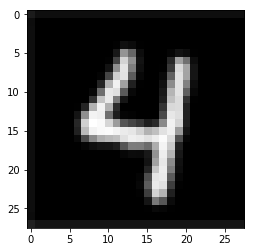

In [23]:
# testing our model
# forward pass through the model
outputs = mlp.fprop(x_new)
outputs = outputs.get()[:, 0]

# examine the output of the model for this image
print("Model final layer was: {}".format(outputs))
print("The most probable guess is digit: {}".format(np.argmax(outputs)))
plt.figure(2)
plt.imshow(img)